### Make some PIC maps for Hilde's study

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import cmocean

from statistics import mean
import scipy.io
import pandas as pd
import utils
import matplotlib.path as mpath

### Ship tracks (a matlab file)

In [4]:
tracks = scipy.io.loadmat('contour_xy.mat')

In [39]:
tracks['xyt'][0]

array([202.16782056, 202.17541343, 202.18296444, ..., 207.82692667,
       207.8212    , 207.81722361])

In [29]:
track_lons_degE = tracks['xyt'][0]
track_lons = 180 - (track_lons_degE - 180)
track_lons = track_lons * -1.

In [7]:
track_lats = tracks['xyt'][1]
track_lats

array([ 20.99352556,  20.94777037,  20.90225556, ..., -27.19514833,
       -27.14890111, -27.116275  ])

In [8]:
track_time = tracks['xyt'][2]
track_time

array([361.32161343, 361.33307099, 361.34452778, ..., 408.72972685,
       408.74014815, 408.74743634])

### Get MODIS chlorophyll/PIC data cumulative mean

In [9]:
file ='/glade/work/kristenk/satellite_data/Chl_cumulative_mean/A20021852020182.L3m_CU_CHL_chlor_a_9km.nc'
ds_chl_mean = xr.open_dataset(file)

In [10]:
sat_lats = ds_chl_mean.lat
sat_lons = ds_chl_mean.lon

In [11]:
file ='/glade/work/kristenk/satellite_data/cumulative_mean_SST/AQUA_MODIS.20020704_20210930.L3m.CU.NSST.sst.9km.nc'
ds_sst = xr.open_dataset(file)

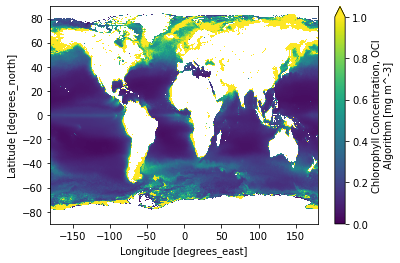

In [12]:
ds_chl_mean.chlor_a.plot(vmin=0,vmax=1)

In [13]:
file ='/glade/work/kristenk/satellite_data/PIC_cumulative_mean/A20021852021031.L3m_CU_PIC_pic_9km.nc'
ds_pic_mean = xr.open_dataset(file)

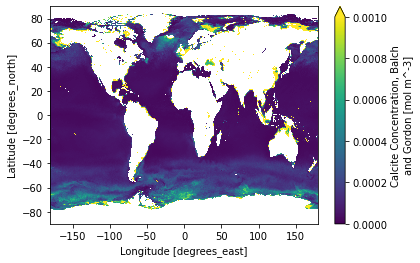

In [14]:
ds_pic_mean.pic.plot(vmin=0,vmax=0.001)

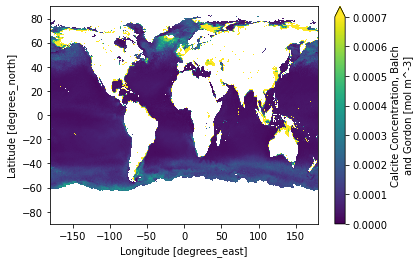

In [18]:
ds_pic_mean.pic.where(ds_sst.sst > 2).plot(vmin=0,vmax=0.0007);

Text(-145, -30, 'Ship track')

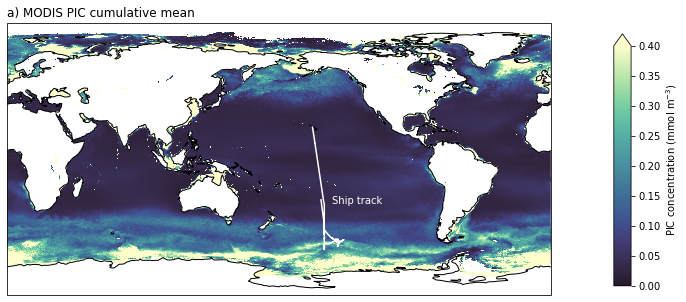

In [38]:
fig = plt.figure(figsize=(12,5))


########################################################################### modis chlorophyll
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=180))

ax.set_title('a) MODIS PIC cumulative mean',loc = 'left')
ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree(central_longitude=180))

ax.coastlines('110m',linewidth=1)

## converting to mmol/m3
pic = (ds_pic_mean.pic * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='PIC concentration (mmol m$^{-3}$)')


ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='white', transform=ccrs.PlateCarree())
ax.text(-145,-30,"Ship track",color='white',transform=ccrs.PlateCarree())

#fig.savefig('/glade/work/kristenk/figs/chl_comparison.png', bbox_inches='tight', dpi=300, format='png');

### get 8 day satellite pic 

In [70]:
path = '/glade/work/kristenk/satellite_data/PIC_match_cruise/'

files = []
files.extend(sorted(glob(f'{path}/*.nc')))
#files
ds=xr.open_mfdataset(files,concat_dim='time',combine='nested')

In [44]:
import matplotlib.ticker as mticker

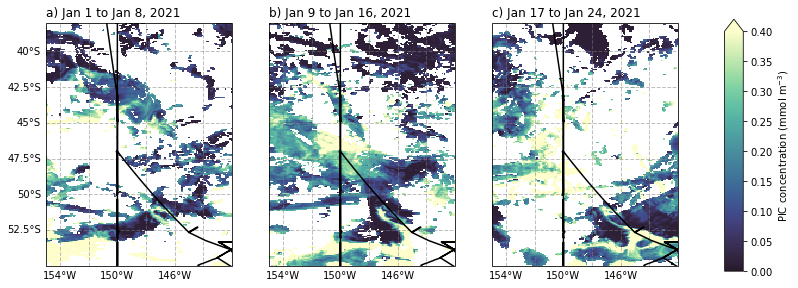

In [59]:
fig = plt.figure(figsize=(13,5))


########################################################################### modis pic 1
ax = fig.add_subplot(1,3,1, projection=ccrs.PlateCarree())

ax.set_title('a) Jan 1 to Jan 8, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=0) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic 2
ax = fig.add_subplot(1,3,2, projection=ccrs.PlateCarree())

ax.set_title('b) Jan 9 to Jan 16, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=1) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())




########################################################################### modis pic 3
ax = fig.add_subplot(1,3,3, projection=ccrs.PlateCarree())

ax.set_title('c) Jan 17 to Jan 24, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=2) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())






fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='PIC concentration (mmol m$^{-3}$)')

#fig.savefig('/glade/work/kristenk/figs/pic_comparison.png', bbox_inches='tight', dpi=300, format='png');

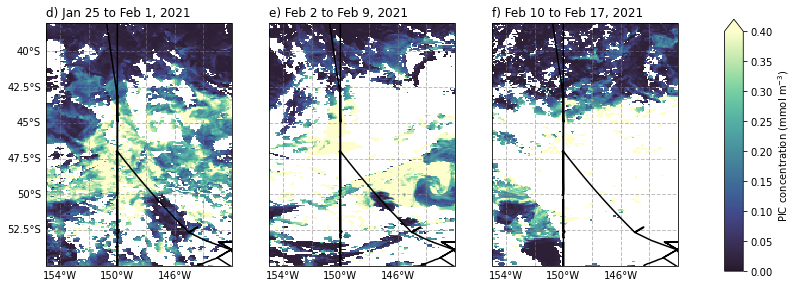

In [60]:
fig = plt.figure(figsize=(13,5))


########################################################################### modis pic 1
ax = fig.add_subplot(1,3,1, projection=ccrs.PlateCarree())

ax.set_title('d) Jan 25 to Feb 1, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=3) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic 2
ax = fig.add_subplot(1,3,2, projection=ccrs.PlateCarree())

ax.set_title('e) Feb 2 to Feb 9, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=4) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())




########################################################################### modis pic 3
ax = fig.add_subplot(1,3,3, projection=ccrs.PlateCarree())

ax.set_title('f) Feb 10 to Feb 17, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=5) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())






fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='PIC concentration (mmol m$^{-3}$)')

#fig.savefig('/glade/work/kristenk/figs/pic_comparison.png', bbox_inches='tight', dpi=300, format='png');

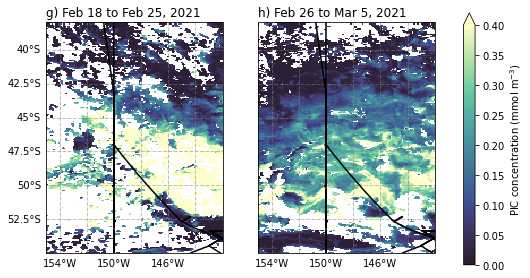

In [61]:
fig = plt.figure(figsize=(8,5))


########################################################################### modis pic 1
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())

ax.set_title('g) Feb 18 to Feb 25, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=6) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic 2
ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())

ax.set_title('h) Feb 26 to Mar 5, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=7) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.4, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='PIC concentration (mmol m$^{-3}$)')

#fig.savefig('/glade/work/kristenk/figs/pic_comparison.png', bbox_inches='tight', dpi=300, format='png');

### Make means over January and February

In [75]:
Jan_pic2021 = ds.pic.isel(time=slice(0,4)).mean(dim='time')
Feb_pic2021 = ds.pic.isel(time=slice(4,8)).mean(dim='time')

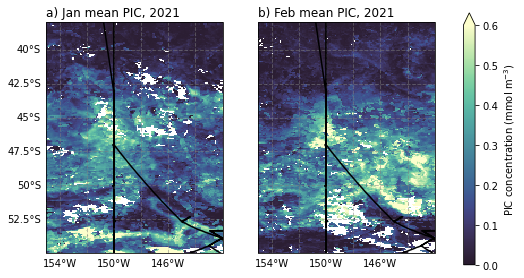

In [78]:
fig = plt.figure(figsize=(8,5))


########################################################################### modis pic 1
ax = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree())

ax.set_title('a) Jan mean PIC, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (Jan_pic2021 * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.6, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic 2
ax = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree())

ax.set_title('b) Feb mean PIC, 2021', loc='left')
ax.set_extent([-155, -142, -55, -38], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (Feb_pic2021 * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=0.6, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='PIC concentration (mmol m$^{-3}$)')

#fig.savefig('/glade/work/kristenk/figs/pic_comparison.png', bbox_inches='tight', dpi=300, format='png');

### Plot PIC monthly climatology

In [62]:
path = '/glade/work/kristenk/satellite_data/Monthly_clim_PIC/'

files = []
files.extend(sorted(glob(f'{path}/*.nc')))
#files
ds=xr.open_mfdataset(files,concat_dim='time',combine='nested')

<xarray.Dataset>
Dimensions:  (eightbitcolor: 256, lat: 2160, lon: 4320, rgb: 3, time: 12)
Coordinates:
  * lat      (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon      (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
Dimensions without coordinates: eightbitcolor, rgb, time
Data variables:
    pic      (time, lat, lon) float32 dask.array<chunksize=(1, 2160, 4320), meta=np.ndarray>
    palette  (time, rgb, eightbitcolor) uint8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      A20030012018031.L3m_MC_PIC_pic_9km.nc
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:                    15-year
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/PIC/2018
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         4922397
    data_minimum:                      1.1995432e-05
    data_maximum:                      0.13053401

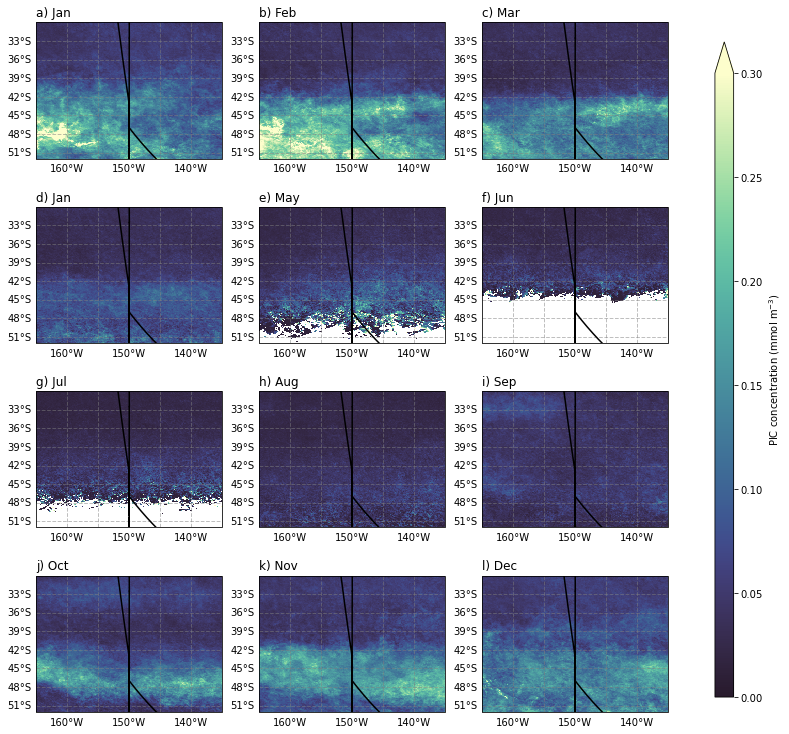

In [69]:
fig = plt.figure(figsize=(13,13))

max_pic = 0.3
########################################################################### modis pic Jan
ax = fig.add_subplot(4,3,1, projection=ccrs.PlateCarree())

ax.set_title('a) Jan', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=0) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Feb
ax = fig.add_subplot(4,3,2, projection=ccrs.PlateCarree())

ax.set_title('b) Feb', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=1) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Feb
ax = fig.add_subplot(4,3,3, projection=ccrs.PlateCarree())

ax.set_title('c) Mar', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=2) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Apr
ax = fig.add_subplot(4,3,4, projection=ccrs.PlateCarree())

ax.set_title('d) Jan', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=3) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic May
ax = fig.add_subplot(4,3,5, projection=ccrs.PlateCarree())

ax.set_title('e) May', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=4) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Jun
ax = fig.add_subplot(4,3,6, projection=ccrs.PlateCarree())

ax.set_title('f) Jun', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=5) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())


########################################################################### modis pic Jul
ax = fig.add_subplot(4,3,7, projection=ccrs.PlateCarree())

ax.set_title('g) Jul', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=6) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Aug
ax = fig.add_subplot(4,3,8, projection=ccrs.PlateCarree())

ax.set_title('h) Aug', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=7) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Sep
ax = fig.add_subplot(4,3,9, projection=ccrs.PlateCarree())

ax.set_title('i) Sep', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=8) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Oct
ax = fig.add_subplot(4,3,10, projection=ccrs.PlateCarree())

ax.set_title('j) Oct', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=9) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())



########################################################################### modis pic Nov
ax = fig.add_subplot(4,3,11, projection=ccrs.PlateCarree())

ax.set_title('k) Nov', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=10) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

########################################################################### modis pic Dec
ax = fig.add_subplot(4,3,12, projection=ccrs.PlateCarree())

ax.set_title('l) Dec', loc='left')
ax.set_extent([-165, -135, -52, -30], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)

## converting to mmol/m3
pic = (ds.pic.isel(time=11) * 1000) #.where(ds_sst.sst > 2)
pc=ax.pcolormesh(ds_pic_mean.lon, ds_pic_mean.lat, pic, 
                 vmin=0, vmax=max_pic, 
                 cmap=cmocean.cm.deep_r,
                 transform=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.plot(track_lons[~np.isnan(track_lons)], track_lats[~np.isnan(track_lats)], color='black', transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='max',label='PIC concentration (mmol m$^{-3}$)')
